<a href="https://colab.research.google.com/github/Diz138/YelpReviews/blob/main/KerasReviewToRating.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# needed libraries
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from nltk.corpus import stopwords 
import nltk
from collections import Counter
import string
import re
import seaborn as sns
import tensorflow as tf
from nltk import word_tokenize
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
nltk.download('stopwords')
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, Dropout
from keras.callbacks import EarlyStopping
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn import metrics

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


In [ ]:
df = pd.read_pickle("/content/drive/MyDrive/CS525/yelp_food_reviews.pkl")
df.head()

,business_id,stars,useful,funny,cool,text,visits,visits_normalized,label
0,XQfwVwDr-v0ZS3_CbbE5Xw,3.0,0,0,0,"If you decide to eat here, just be aware it is...",177.0,35.400000,1.0
3,kxX2SOes4o-D3ZQBkiMRfA,5.0,1,0,1,"Wow! Yummy, different, delicious. Our favo...",204.0,18.545455,1.0
5,04UD14gamNjLY0IDYVhHJg,1.0,1,2,1,I am a long term frequent customer of this est...,290.0,24.166667,1.0
7,LHSTtnW3YHCeUkRDGyJOyw,5.0,2,0,0,Amazingly amazing wings and homemade bleu chee...,84.0,12.000000,0.0
9,gebiRewfieSdtt17PTW6Zg,3.0,0,0,0,Had a party of 6 here for hibachi. Our waitres...,1050.0,87.500000,2.0


In [ ]:
# sample = 10000
subset = df[['text','stars']].sample(n=10000, random_state=8)
subset.head()

,text,stars
4926291,My husband & I LOVE Old Castle. It's one of ou...,5.0
6032203,"Loved it here! The food was so delicious, lite...",4.0
1243368,"Take out order for dinner with family tonight,...",4.0
2410403,Went for a simple steak dinner with a business...,5.0
5174983,Had a very disappointing experience at Trailhe...,2.0


In [ ]:
# preprocessing
subset = subset.reset_index(drop=True)
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    text = text.lower()
    text = REPLACE_BY_SPACE_RE.sub(' ', text)
    text = BAD_SYMBOLS_RE.sub('', text)
    text = ' '.join(word for word in text.split() if word not in STOPWORDS)
    return text
subset['text'] = subset['text'].apply(clean_text)

In [ ]:
MAX_NB_WORDS = 50000

MAX_SEQUENCE_LENGTH = 1500
# dimension per embedding
EMBEDDING_DIM = 100


tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(subset['text'].values)

In [ ]:
X = tokenizer.texts_to_sequences(subset['text'].values)
X = tf.keras.preprocessing.sequence.pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)

In [ ]:
# get labels
Y = pd.get_dummies(subset['stars']).values

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.10, random_state = 42)

In [ ]:
# create model, add layers
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(5, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
epochs = 5
batch_size = 64

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Epoch 1/5
127/127 [==============================] - 856s 7s/step - loss: 1.2179 - accuracy: 0.4954 - val_loss: 1.0033 - val_accuracy: 0.5644
Epoch 2/5
127/127 [==============================] - 849s 7s/step - loss: 0.9038 - accuracy: 0.5937 - val_loss: 0.9605 - val_accuracy: 0.5811
Epoch 3/5
127/127 [==============================] - 851s 7s/step - loss: 0.7148 - accuracy: 0.6953 - val_loss: 0.9656 - val_accuracy: 0.5933
Epoch 4/5
127/127 [==============================] - 852s 7s/step - loss: 0.5368 - accuracy: 0.7830 - val_loss: 1.0062 - val_accuracy: 0.6200
Epoch 5/5
127/127 [==============================] - 851s 7s/step - loss: 0.3911 - accuracy: 0.8548 - val_loss: 1.1690 - val_accuracy: 0.5956


In [ ]:
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

32/32 [==============================] - 13s 419ms/step - loss: 1.2133 - accuracy: 0.5890
Test set
  Loss: 1.213
  Accuracy: 0.589


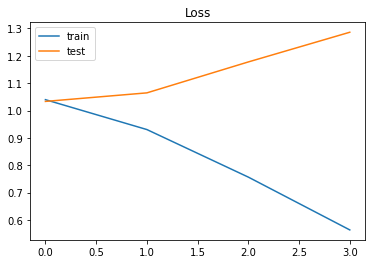

In [ ]:
# plot the loss of the model with training and testing
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();


{'loss': [1.0396554470062256, 0.9303741455078125, 0.7564365863800049, 0.5633311867713928], 'accuracy': [0.49185848236083984, 0.5603024959564209, 0.6761605143547058, 0.7736380100250244], 'val_loss': [1.0332773923873901, 1.0645133256912231, 1.1776520013809204, 1.2862329483032227], 'val_accuracy': [0.50124192237854, 0.468455046415329, 0.47093889117240906, 0.49130651354789734]}


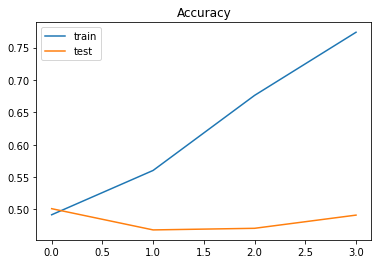

In [ ]:
# plot the accuracy of the model with train and testing
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show();


In [ ]:
# get model predictions on test set
predicted = model.predict(X_test)

32/32 [==============================] - 13s 418ms/step


In [ ]:
# grab the most likely values from predicted and labels
predicted = np.argmax(predicted, axis=1)
Y_test = np.argmax(Y_test, axis=1)

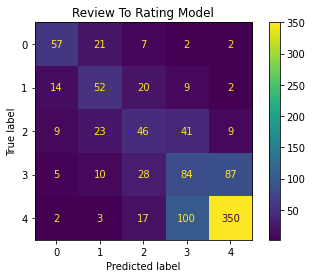

In [ ]:
# Create confusion matrix
confusion_matrix = metrics.confusion_matrix(Y_test,predicted)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix,display_labels=[0,1,2,3,4])

cm_display.plot()
plt.title("Review To Rating Model")
plt.show()